In [18]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# preds

In [42]:
preds = pd.read_csv('val_results/best_models_with_multi/res_0.7_0.2_h-r_r-t_h-t_r-h_t-r.csv')

In [124]:
preds.sort_values(by='f1', ascending=False).head(10)

,rel,label,size,precision,recall,f1,tps,fps,rel_acc
20,P61,discoverer or inventor,47.0,0.338983,0.769231,0.470588,"{0: [('It', 'American astronomers Eleanor Helin', 'discovered', 'P61', 0.99785244)], 2: [('It', 'German astronomer Max Wolf', 'discovered', 'P61', 0.99544984)], 3: [('It', 'Johann Palisa', 'discov...","{0: [('It', 'the U.S.', 'discovered', 'P61', 0.9960879), ('It', 'Kenneth J. Lawrence', 'discovered', 'P61', 0.9978727)], 1: [('It', 'February', 'discovered', 'P61', 0.8521578)], 3: [('It', 'Novemb...",0.950000
2,P19,place of birth,45.0,0.323529,0.814815,0.463158,"{0: [('He', 'County Down', 'born', 'P19', 0.9893974)], 2: [('He', 'Haapsalu', 'born', 'P19', 0.9564518)], 3: [('He', 'Trier', 'born', 'P19', 0.99623233)], 4: [('He', 'Milan', 'born', 'P19', 0.9863...","{0: [('Margaret Garrett', 'He', 'the son', 'P40', 0.22603907), ('William Kidd', 'He', 'the son', 'P40', 0.5031858), ('He', 'Margaret Garrett', 'born', 'P19', 0.9442325), ('He', 'William Kidd', 'bo...",0.977273
28,P115,home venue,40.0,0.490196,0.438596,0.462963,"{0: [('CD Badajoz', 'It', 'the home ground', 'P115', 0.6651741)], 1: [('PFC Lokomotiv Plovdiv', 'It', 'the home ground', 'P115', 0.61277825)], 3: [('Moroka Swallows', 'It', 'the home ground', 'P11...","{4: [('It', 'Club Sportif Sfaxien', 'the home stadium', 'P403', 0.2385932)], 5: [('It', 'HNK Cibalia', 'the home ground', 'P403', 0.21513693)], 6: [('The club', 'the original owners', 'were', 'P13...",1.000000
77,P647,drafted by,44.0,0.294118,0.888889,0.441989,"{0: [('He', 'the Calgary Flames', 'drafted', 'P647', 0.90336055)], 2: [('he', 'the Boston Celtics', 'drafted', 'P647', 0.7507321)], 3: [('He', 'the Columbus Blue Jackets', 'drafted', 'P647', 0.862...","{0: [('He', 'the 2006 NHL Entry Draft', 'drafted', 'P647', 0.6806591), ('He', 'the 209th pick', 'drafted', 'P647', 0.4264229)], 1: [('player', 'NBA team', 'be', 'P361', 0.3773199)], 2: [('He', 'Un...",1.000000
21,P69,educated at,47.0,0.309677,0.705882,0.430493,"{1: [('He', 'Harrow', 'educated', 'P69', 0.9799867)], 2: [('She', 'Eastbourne College', 'educated', 'P69', 0.97397804)], 3: [('She', 'Oslo', 'graduated', 'P69', 0.96685725)], 4: [('He', 'Oxford', ...","{1: [('He', 'Sandhurst', 'educated', 'P69', 0.9370623)], 2: [('She', 'Cambridge', 'read', 'P69', 0.6651904), ('She', 'Trinity College', 'read', 'P69', 0.6405624), ('She', 'Blackheath High School',...",1.000000
18,P57,director,43.0,0.355263,0.519231,0.421875,"{0: [('It', 'Gwyneth Horder-Payton', 'directed', 'P57', 0.22292233), ('It', 'series creator Robert Kirkman', 'directed', 'P1191', 0.20501949)], 1: [('It', 'James Sibley Watson', 'directed', 'P57',...","{0: [('It', 'Ardeth Bey', 'written', 'P50', 0.28287628), ('It', 'Ernest Dickerson', 'written', 'P50', 0.26695296)], 1: [('It', 'Melville Webber', 'directed', 'P57', 0.8619079), ('James Sibley Wats...",0.666667
30,P119,place of burial,45.0,0.272109,0.784314,0.404040,"{0: [('He', 'Canongate Churchyard', 'buried', 'P119', 0.99914944)], 1: [('He', 'Toronto', 'buried', 'P119', 0.8817418), ('He', 'Mount Pleasant Cemetery', 'buried', 'P119', 0.9951651)], 2: [('He', ...","{0: [('James', 'He', 'his son', 'P26', 0.48480588), ('He', 'James', 'his son', 'P26', 0.24314445), ('bears', 'Medicine', 'Professor', 'P1303', 0.37045953), ('the plot', 'Medicine', 'Professor', 'P...",1.000000
36,P138,named after,44.0,0.280992,0.666667,0.395349,"{2: [('It', 'Jacques Hadamard', 'named', 'P138', 0.86812335), ('It', 'German mathematician Issai Schur', 'named', 'P138', 0.808983)], 3: [('It', 'the ruined Lesnes Abbey', 'named', 'P138', 0.39340...","{2: [('It', 'mathematician', 'named', 'P138', 0.4403834)], 3: [('It', 'Bexley', 'named', 'P138', 0.35794714), ('It', 'the London Borough', 'located', 'P276', 0.7495712), ('the Abbey Wood district'...",1.000000
91,P1411,nominated for,40.0,0.304348,0.500000,0.378378,"{2: [('It', 'Best Documentary Feature', 'nominated', 'P1411', 0.99777514)], 4: [('It', 'Best Live Action Short Film', 'nominated', 'P1411', 0.97556794)], 8: [('The 

In [189]:
def vizualizer(dataframe_with_predicts, rel=None, default_type=True):
    vals = dataframe_with_predicts.tps.values.tolist() + dataframe_with_predicts.fps.values.tolist()
    triplets = []
    for val in vals:
        try:
            if default_type:
                sub_vals = list(eval(val).values())
            else:
                sub_vals = list(eval(val))
        except SyntaxError:
            continue
        for sub_v in sub_vals:
            if default_type:
                triplets.append(list(sub_v[0][:2]) + [sub_v[0][3]])
            else:
                triplets.append(list(sub_v[:3]))
    kg_df = pd.DataFrame(triplets, columns=['source', 'target', 'edge']).drop_duplicates()
    if rel:
        G=nx.from_pandas_edgelist(kg_df[kg_df['edge'].str.contains(rel)], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
    else:
        G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
    edge_labels = dict([((n1, n2), f'{n1}->{n2}')
                    for n1, n2 in G.edges])

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.figure(figsize=(25, 25))
    pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=300, edge_cmap=plt.cm.Blues, pos = pos)
    plt.savefig(f'{rel}.png',  dpi=500)
    plt.show()

In [307]:
preds

,rel,label,size,precision,recall,f1,tps,fps,rel_acc
0,P6,head of government,37.000000,0.153846,0.410256,0.223776,"{0: [('Jerusalem', 'He', 'first elected mayor', 'P6', 0.9640999)], 3: [('Dessel', 'He', 'mayor', 'P6', 0.6122008)], 6: [('Tynset', 'He', 'the mayor', 'P6', 0.57612884)], 11: [('Guangzhou', 'Heyuan...","{0: [('He', 'Jerusalem', 'first elected mayor', 'P131', 0.5164461)], 3: [('Dessel', 'mayor', 'been', 'P31', 0.4061196), ('the Municipal Council', 'mayor', 'been', 'P31', 0.29654163), ('He', 'mayor...",1.000000
1,P17,country,34.000000,0.112426,0.351852,0.170404,"{0: [('Minas Gerais', 'Brazil', 'the state', 'P17', 0.5106824)], 2: [('Karnataka', 'India', 'the southern state', 'P17', 0.89622897)], 7: [('It', 'India', 'the nation', 'P740', 0.28040043)], 8: [(...","{0: [('Braúnas', 'Brazil', 'the state', 'P17', 0.33805668), ('Brazil', 'Minas Gerais', 'the Southeast region', 'P194', 0.252383)], 1: [('Finland', 'Mariehamn', 'the team', 'P150', 0.46800095), ('F...",0.894737
2,P19,place of birth,45.000000,0.323529,0.814815,0.463158,"{0: [('He', 'County Down', 'born', 'P19', 0.9893974)], 2: [('He', 'Haapsalu', 'born', 'P19', 0.9564518)], 3: [('He', 'Trier', 'born', 'P19', 0.99623233)], 4: [('He', 'Milan', 'born', 'P19', 0.9863...","{0: [('Margaret Garrett', 'He', 'the son', 'P40', 0.22603907), ('William Kidd', 'He', 'the son', 'P40', 0.5031858), ('He', 'Margaret Garrett', 'born', 'P19', 0.9442325), ('He', 'William Kidd', 'bo...",0.977273
3,P20,place of death,50.000000,0.193939,0.561404,0.288288,"{0: [('He', 'Erlangen', 'died', 'P20', 0.9922956)], 1: [('He', 'Marshall', 'died', 'P20', 0.9981938), ('He', 'Michigan', 'died', 'P20', 0.9998733)], 4: [('He', 'Tehran', 'died', 'P20', 0.9993113)]...","{1: [('He', 'March', 'died', 'P570', 0.9955812), ('Marshall', 'March', 'died', 'P571', 0.5616262), ('Marshall', 'Michigan', 'died', 'P131', 0.260442), ('Michigan', 'March', 'died', 'P571', 0.53369...",0.968750
4,P22,father,39.000000,0.216216,0.510638,0.303797,"{0: [('Georg Jacob Bull', 'He', 'the father', 'P22', 0.53984463)], 2: [('Randy Savage', 'He', 'the father', 'P22', 0.636075), ('""The Genius"" Lanny Poffo', 'He', 'the father', 'P22', 0.4267897), ('...","{0: [('He', 'Georg Jacob Bull', 'the father', 'P26', 0.2523154)], 2: [('He', 'Randy Savage', 'the father', 'P26', 0.4975589)], 4: [('Koja Zaharia', 'He', 'his father', 'P26', 0.23030204), ('Koja',...",0.791667
...,...,...,...,...,...,...,...,...,...
91,P1411,nominated for,40.000000,0.304348,0.500000,0.378378,"{2: [('It', 'Best Documentary Feature', 'nominated', 'P1411', 0.99777514)], 4: [('It', 'Best Live Action Short Film', 'nominated', 'P1411', 0.97556794)], 8: [('The Divorcee', 'Best Actress', 'nomi...","{0: [('Ave Satani', 'The Omen', 'songs', 'P800', 0.21847366), ('The Omen', 'the Academy Award', 'won', 'P1303', 0.358725)], 1: [('Gregg Toland', 'an Academy Award', 'nominated', 'P1411', 0.4349311...",1.000000
92,P1619,date of official opening,42.000000,0.219512,0.418605,0.288000,"{3: [('the Liverpool and Manchester Railway (L&M', 'September', 'opened', 'P1619', 0.9060832)], 4: [('Vaughan Mills', 'November', 'opened', 'P1619', 0.9952567)], 6: [('It', 'April', 'opened', 'P16...","{3: [('It', 'September', 'opened', 'P1619', 0.990063)], 4: [('the Erin Mills Town Centre', 'November', 'opened', 'P1619', 0.9831707), ('the Greater Toronto Area', 'November', 'opened', 'P1619', 0....",1.000000
93,P2176,drug or therapy used for treatment,35.000000,0.093333,0.134615,0.110236,"{0: [('both ventricular fibrillation', 'sotalol', 'treatment', 'P2176', 0.67408186)], 11: [('schizophrenia', 'Thorazine', 'market', 'P178', 0.30088845)], 21: [('schizophrenia', 'Loxapine', 'the tr...","{0: [('sotalol', 'it', 'treatment', 'P828', 0.22869049), ('both ventricular fibrillation', 'it', 'treatment', 'P2176', 0.81893384), ('ventricular tachycardia', 'it', 'treatment', 'P2176', 0.673642...",0.857143
94,P2184,history of topic,28.000000,0.012195,0.034483,0.018018,"{22: [('France', 'French history', 'History', 'P

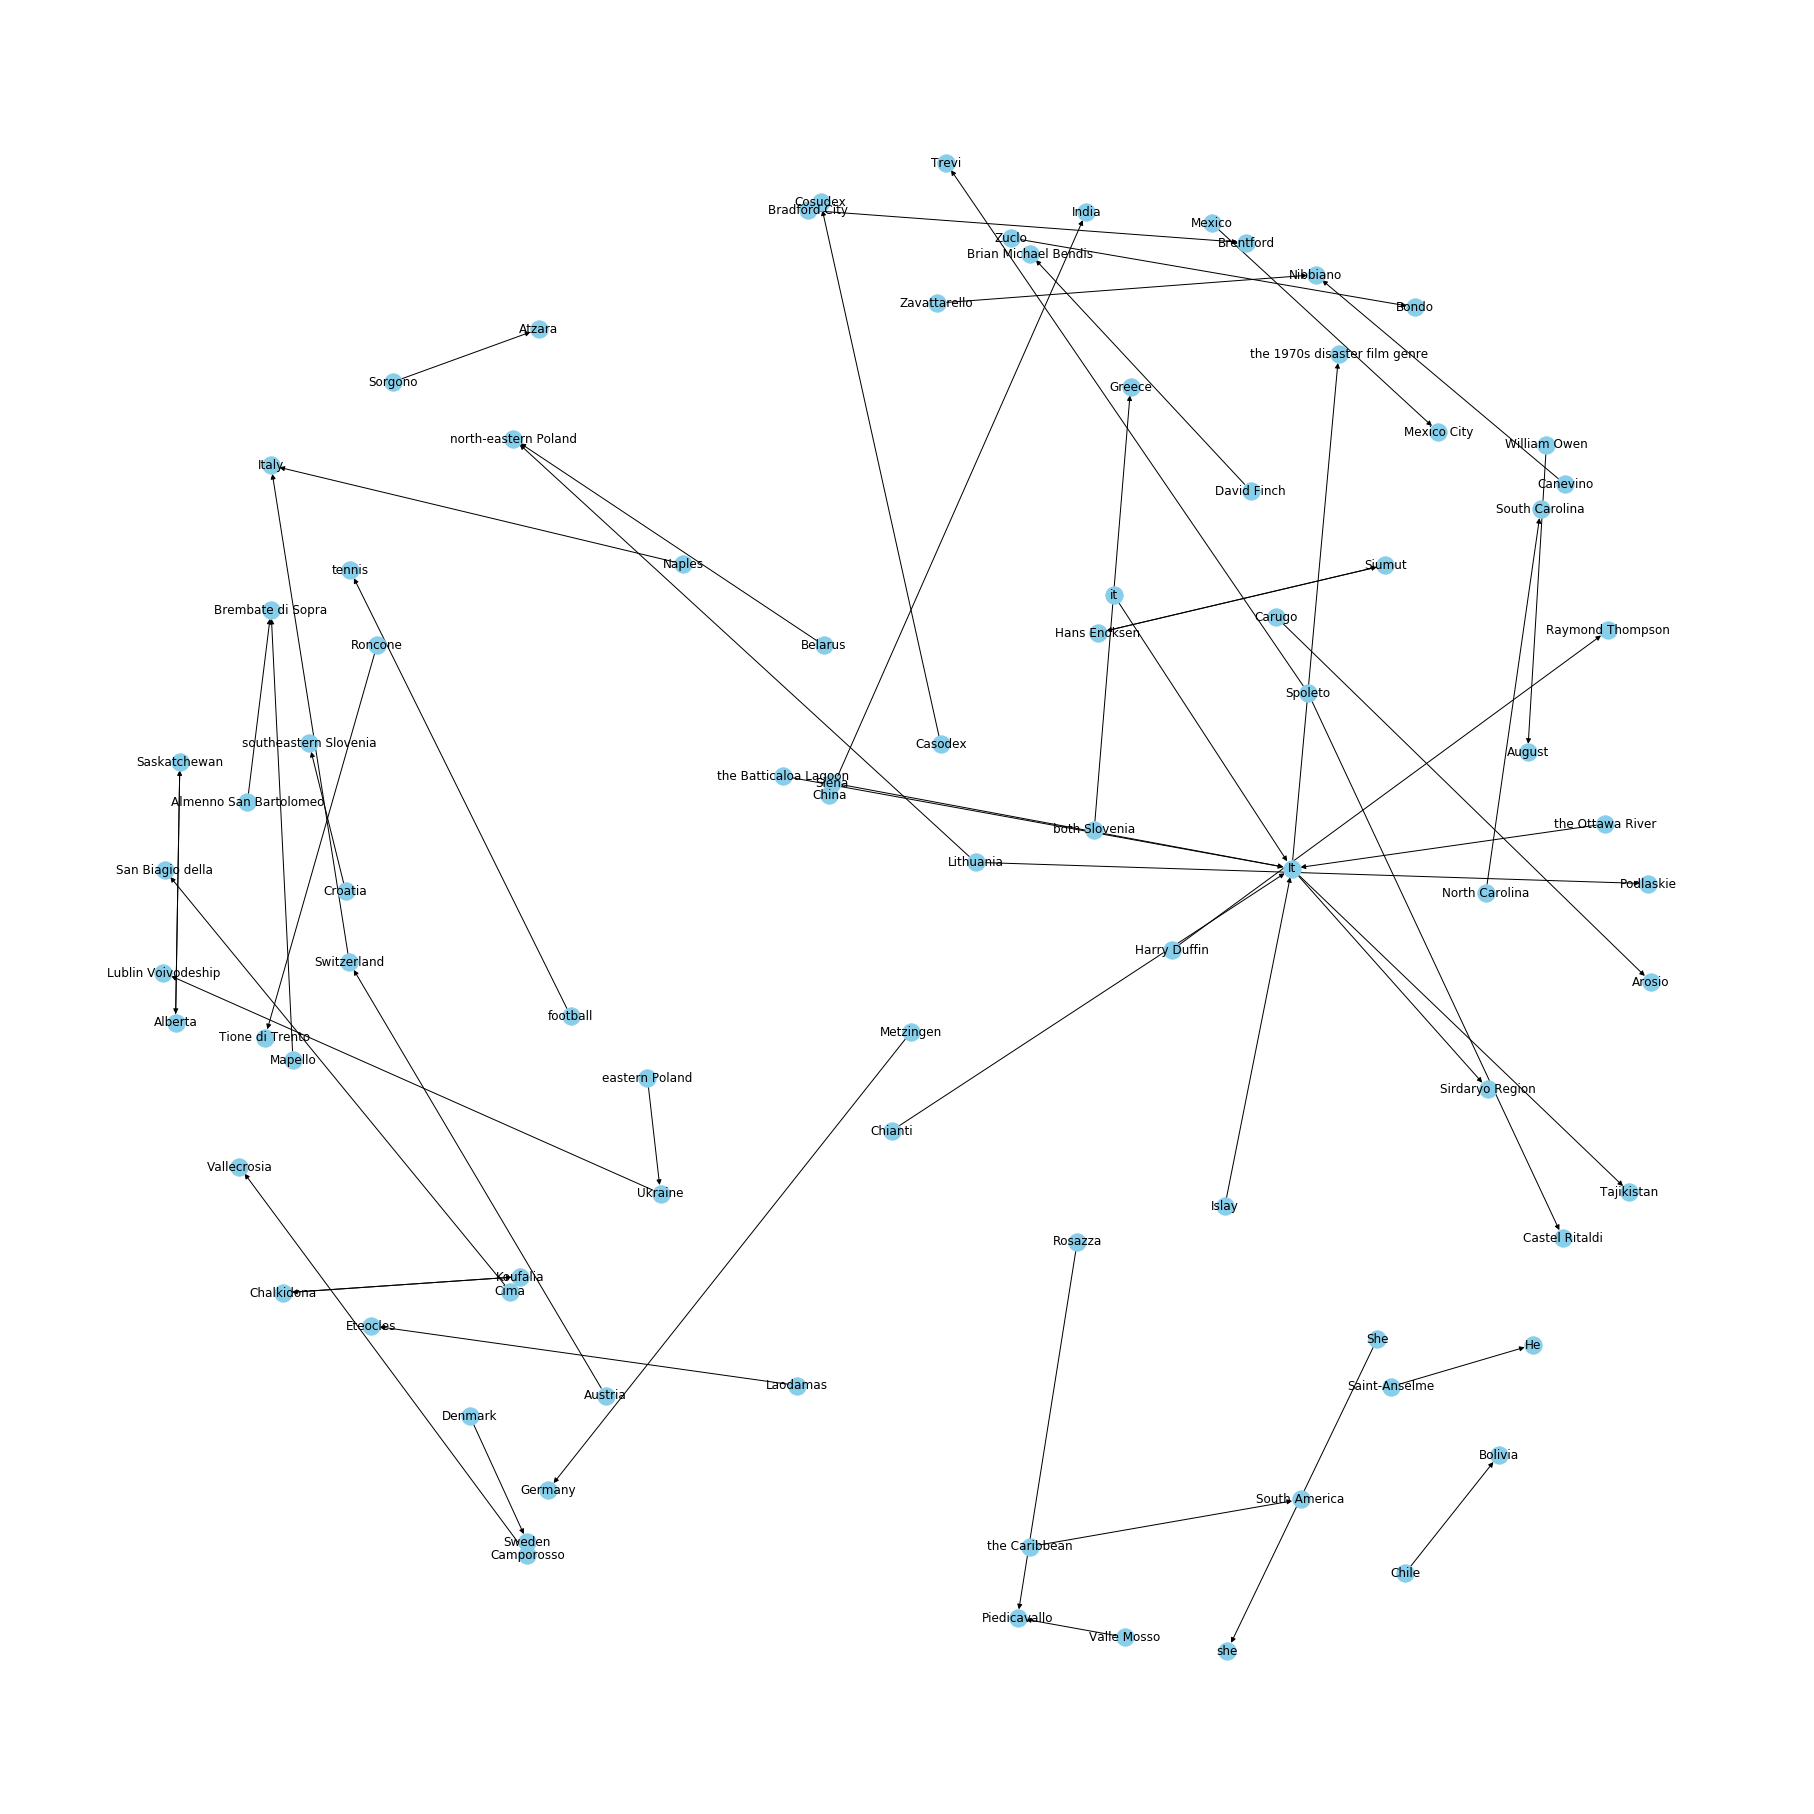

In [196]:
vizualizer(preds, 'P47')

# viz long texts

In [128]:
candidates = pd.read_csv('../kg-extracting-probing/data/meta/trex_data_long_parsed.csv')

In [145]:
candidates['f1'] = 2 * candidates['precision'] * candidates['recall'] / (candidates['precision'] + candidates['recall'])

In [146]:
candidate.f1.mean()

0.006942997314602979

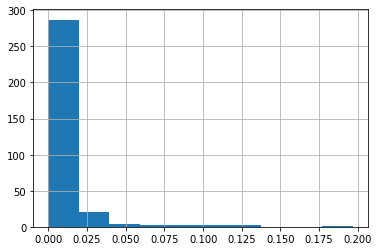

In [130]:
candidate.f1.hist()

In [171]:
candidate.target.values[0]

"[('Teramo', 'Pescara', 'borders', 'P47'), ('Teramo', 'Rieti', 'borders', 'P47'), ('Teramo', 'It', 'borders', 'P47'), ('Pescara', 'Teramo', 'borders', 'P47'), ('Pescara', 'Chieti', 'borders', 'P47'), ('Pescara', 'It', 'borders', 'P47'), ('Chieti', 'Pescara', 'borders', 'P47'), ('Chieti', 'Isernia', 'borders', 'P47'), ('Chieti', 'It', 'borders', 'P47'), ('Isernia', 'Chieti', 'borders', 'P47'), ('Isernia', 'Frosinone', 'borders', 'P47'), ('Isernia', 'It', 'borders', 'P47'), ('Molise', 'Lazio', 'borders', 'P47'), ('Frosinone', 'Isernia', 'borders', 'P47'), ('Frosinone', 'It', 'borders', 'P47'), ('Rieti', 'Teramo', 'borders', 'P47'), ('Rieti', 'It', 'borders', 'P47'), ('Lazio', 'Molise', 'borders', 'P47'), ('It', 'Teramo', 'borders', 'P47'), ('It', 'Pescara', 'borders', 'P47'), ('It', 'Chieti', 'borders', 'P47'), ('It', 'Isernia', 'borders', 'P47'), ('It', 'Frosinone', 'borders', 'P47'), ('It', 'Rieti', 'borders', 'P47'), ('Apennines', 'Corno Grande', 'highest peak', 'P610')]"

# todo:
- проналазировать туду с местоимениями, может не стоит делать coreference, так как модель может в it ссылаться на какой-то неочевидный relation

In [188]:
candidate.sort_values(by='f1', ascending=False).reset_index(drop=True).head(10)

,text,target,tokenized,num_sents,sent_max_len,sent_max_tokens,precision,recall,f1,tps,fps,preds
0,"The Province of L'Aquila (Provincia dell'Aquila) is the largest, most mountainous and least densely populated province of the Abruzzo region of Southern Italy. It comprises about half the landmass...","[('Teramo', 'Pescara', 'borders', 'P47'), ('Teramo', 'Rieti', 'borders', 'P47'), ('Teramo', 'It', 'borders', 'P47'), ('Pescara', 'Teramo', 'borders', 'P47'), ('Pescara', 'Chieti', 'borders', 'P47'...","[""The Province of L'Aquila (Provincia dell'Aquila) is the largest, most mountainous and least densely populated province of the Abruzzo region of Southern Italy."", 'It comprises about half the lan...",8,234,35,0.200000,0.193548,0.196721,"[('It', 'Rieti', 'borders'), ('It', 'Frosinone', 'borders'), ('It', 'Pescara', 'borders'), ('It', 'Teramo', 'borders'), ('It', 'Chieti', 'borders'), ('It', 'Isernia', 'borders')]","[('It', 'Abruzzo', 'occupies'), ('It', 'Lazio region', 'borders'), ('It', 'Molise region', 'borders'), ('It', 'Rome', 'borders'), ('the provinces', 'It', 'Pescara'), ('the provinces', 'Pescara', '...","[('borders', 'Teramo', 'has'), ('It', 'Chieti', 'borders'), ('glacier', ""L'Aquila"", 'the Calderone'), ('glacier', 'the highest mountains', 'the Calderone'), ('It', 'Lazio region', 'borders'), ('It..."
1,"Tanzania /ˌtænzəˈniːə/, officially the United Republic of Tanzania (Swahili: Jamhuri ya Muungano wa Tanzania), is a country in East Africa within the African Great Lakes region. It is bordered by ...","[('Kenya', 'Uganda', 'bordered by', 'P47'), ('Kenya', 'It', 'bordered by', 'P47'), ('Uganda', 'Kenya', 'bordered by', 'P47'), ('Uganda', 'Rwanda', 'bordered by', 'P47'), ('Uganda', 'Congo', 'borde...","['Tanzania /ˌtænzəˈniːə/, officially the United Republic of Tanzania (Swahili: Jamhuri ya Muungano wa Tanzania), is a country in East Africa within the African Great Lakes region.', 'It is bordere...",10,202,36,0.200000,0.097561,0.131148,"[('It', 'Malawi', 'bordered'), ('It', 'Mozambique', 'bordered'), ('It', 'the Congo', 'bordered'), ('It', 'Burundi', 'bordered')]","[('a country', 'wa', 'Tanzania'), ('a country', 'East Africa', 'Tanzania'), ('a country', 'Jamhuri ya Muungano', 'Tanzania'), ('a country', '(Swahili', 'Tanzania'), ('Tanzania', 'the African Great...","[('its official capital', 'Dodoma', 'Tanzania'), ('its official capital', 'Tanzania', 'Dodoma'), ('a country', '(Swahili', 'Tanzania'), ('their respective independence', 'Tanzania', 'the United Re..."
2,"Berkshire (/ˈbɑːrkʃər/ or /ˈbɑːrkʃɪər/, abbreviated Berks) is a county of south east England, located to the west of London. It has also been known as the Royal County of Berkshire since at least ...","[('Berkshire', 'county', 'is a', 'P31'), ('Berkshire', 'historic origin', 'is a', 'P31'), ('Berkshire', 'county', 'is a', 'P31'), ('Berkshire', 'non-metropolitan', 'is a', 'P31'), ('Berkshire', 'c...","['Berkshire (/ˈbɑːrkʃər/ or /ˈbɑːrkʃɪər/, abbreviated Berks) is a county of south east England, located to the west of London.', 'It has also been known as the Royal County of Berkshire since at l...",8,212,40,0.096154,0.178571,0.125000,"[('It', 'Hampshire', 'borders'), ('It', 'Wiltshire', 'borders'), ('It', 'Surrey', 'borders'), ('It', 'Oxfordshire', 'borders'), ('It', 'Buckinghamshire', 'borders')]","[('a county', 'Berkshire', 'Berks'), ('the west', 'London', 'Berkshire'), ('/ˈbɑːrkʃɪər/', 'London', 'Berkshire'), ('a county', 'London', 'the west'), ('the west', 'Berkshire', 'Berks'), ('/ˈbɑːrk...","[('It', 'Buckinghamshire', 'borders'), ('The towns', 'Oxfordshire', 'Reading'), ('the separate administration', 'Slough', 'ended'), ('Berkshire', 'Wokingham', 'governed'), ('It', 'the south', 'bor..."
3,"Metropolitan Cork is an unofficial term which refers to the city of Cork, Ireland, its suburbs, rural hinterland that surround it and many towns and villages in that hinterland. The term was used ...","[('Ballincollig', 'Cork', 'city', 'P131'), ('Ballincollig', 'Cork', 'c

In [204]:
pd.DataFrame(candidate.sort_values(by='f1', ascending=False).reset_index(drop=True).iloc[7,:]).T.text.values

array(['Greater Manchester is a metropolitan county in North West England, with a population of 2.7 million. It encompasses one of the largest metropolitan areas in the United Kingdom and comprises ten metropolitan boroughs: Bolton, Bury, Oldham, Rochdale, Stockport, Tameside, Trafford, Wigan, and the cities of Manchester and Salford. Greater Manchester was created on 1 April 1974 as a result of the Local Government Act 1972; and designated a City Region on 1 April 2011. Greater Manchester spans 493 square miles (1,277 km2), which roughly covers the territory of the Greater Manchester Built-up Area, the second most populous urban area in the UK. It is landlocked and borders Cheshire (to the south-west and south), Derbyshire (to the south-east), West Yorkshire (to the north-east), Lancashire (to the north) and Merseyside (to the west). There is a mix of high-density urban areas, suburbs, semi-rural and rural locations in Greater Manchester, but land use is mostly urban — the product of 

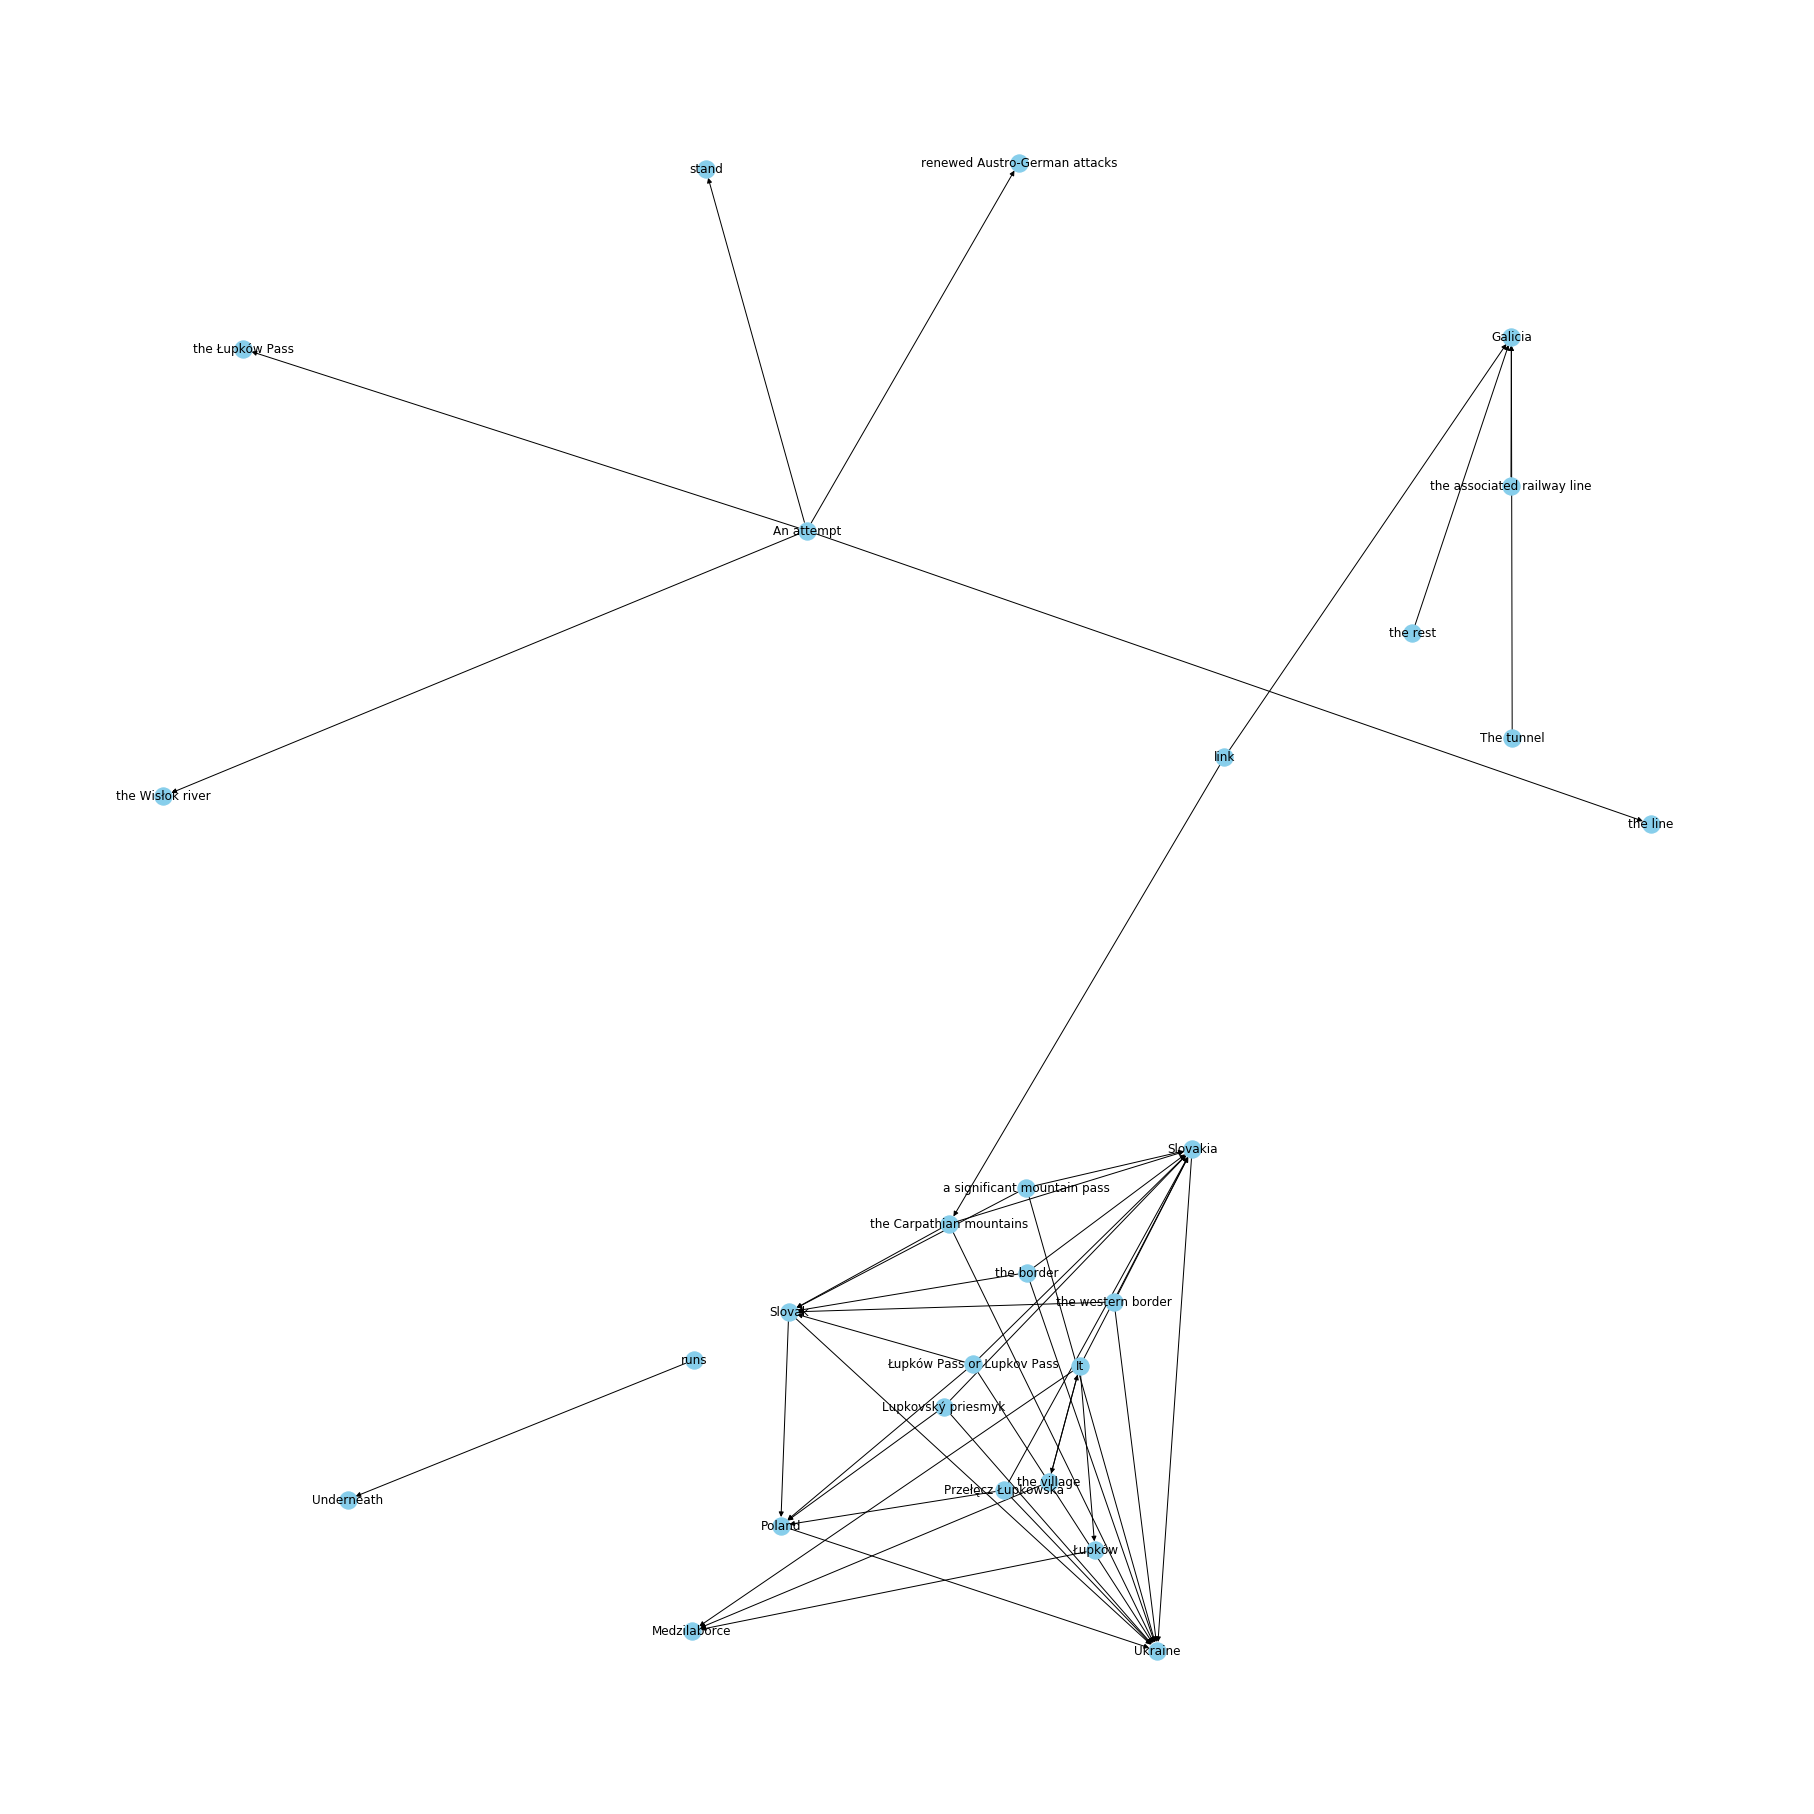

In [215]:
vizualizer(pd.DataFrame(candidate.sort_values(by='f1', ascending=False).loc[271,:]).T, default_type=False)

In [182]:
pd.DataFrame(candidate.sort_values(by='f1', ascending=False).reset_index(drop=True).iloc[3,:]).T

,text,target,tokenized,num_sents,sent_max_len,sent_max_tokens,precision,recall,f1,tps,fps,preds
3,"Metropolitan Cork is an unofficial term which refers to the city of Cork, Ireland, its suburbs, rural hinterland that surround it and many towns and villages in that hinterland. The term was used ...","[('Ballincollig', 'Cork', 'city', 'P131'), ('Ballincollig', 'Cork', 'city', 'P131'), ('Blarney', 'Cork', 'city', 'P131'), ('Blarney', 'Cork', 'city', 'P131'), ('Carrigaline', 'Cork', 'city', 'P131...","['Metropolitan Cork is an unofficial term which refers to the city of Cork, Ireland, its suburbs, rural hinterland that surround it and many towns and villages in that hinterland.', 'The term was ...",7,420,61,0.075472,0.266667,0.117647,"[('Glanmire', 'Cork', 'the city'), ('Crosshaven', 'Cork', 'the city'), ('Glounthaune', 'Cork', 'the city'), ('Carrigtwohill', 'Cork', 'the city'), ('Ringaskiddy', 'Cork', 'the city'), ('Midleton',...","[('an unofficial term', 'Metropolitan Cork', 'Cork'), ('refers', 'Metropolitan Cork', 'Cork'), ('many towns', 'Metropolitan Cork', 'Cork'), ('surround', 'Metropolitan Cork', 'Cork'), ('villages', ...","[('Ringaskiddy', 'authorities', 'been'), ('that hinterland', 'Cork', 'Ireland'), ('covers', 'Cork', 'the city'), ('The term', 'Glanmire', 'taken'), ('The term', 'Blarney', 'taken'), ('Study Final ..."


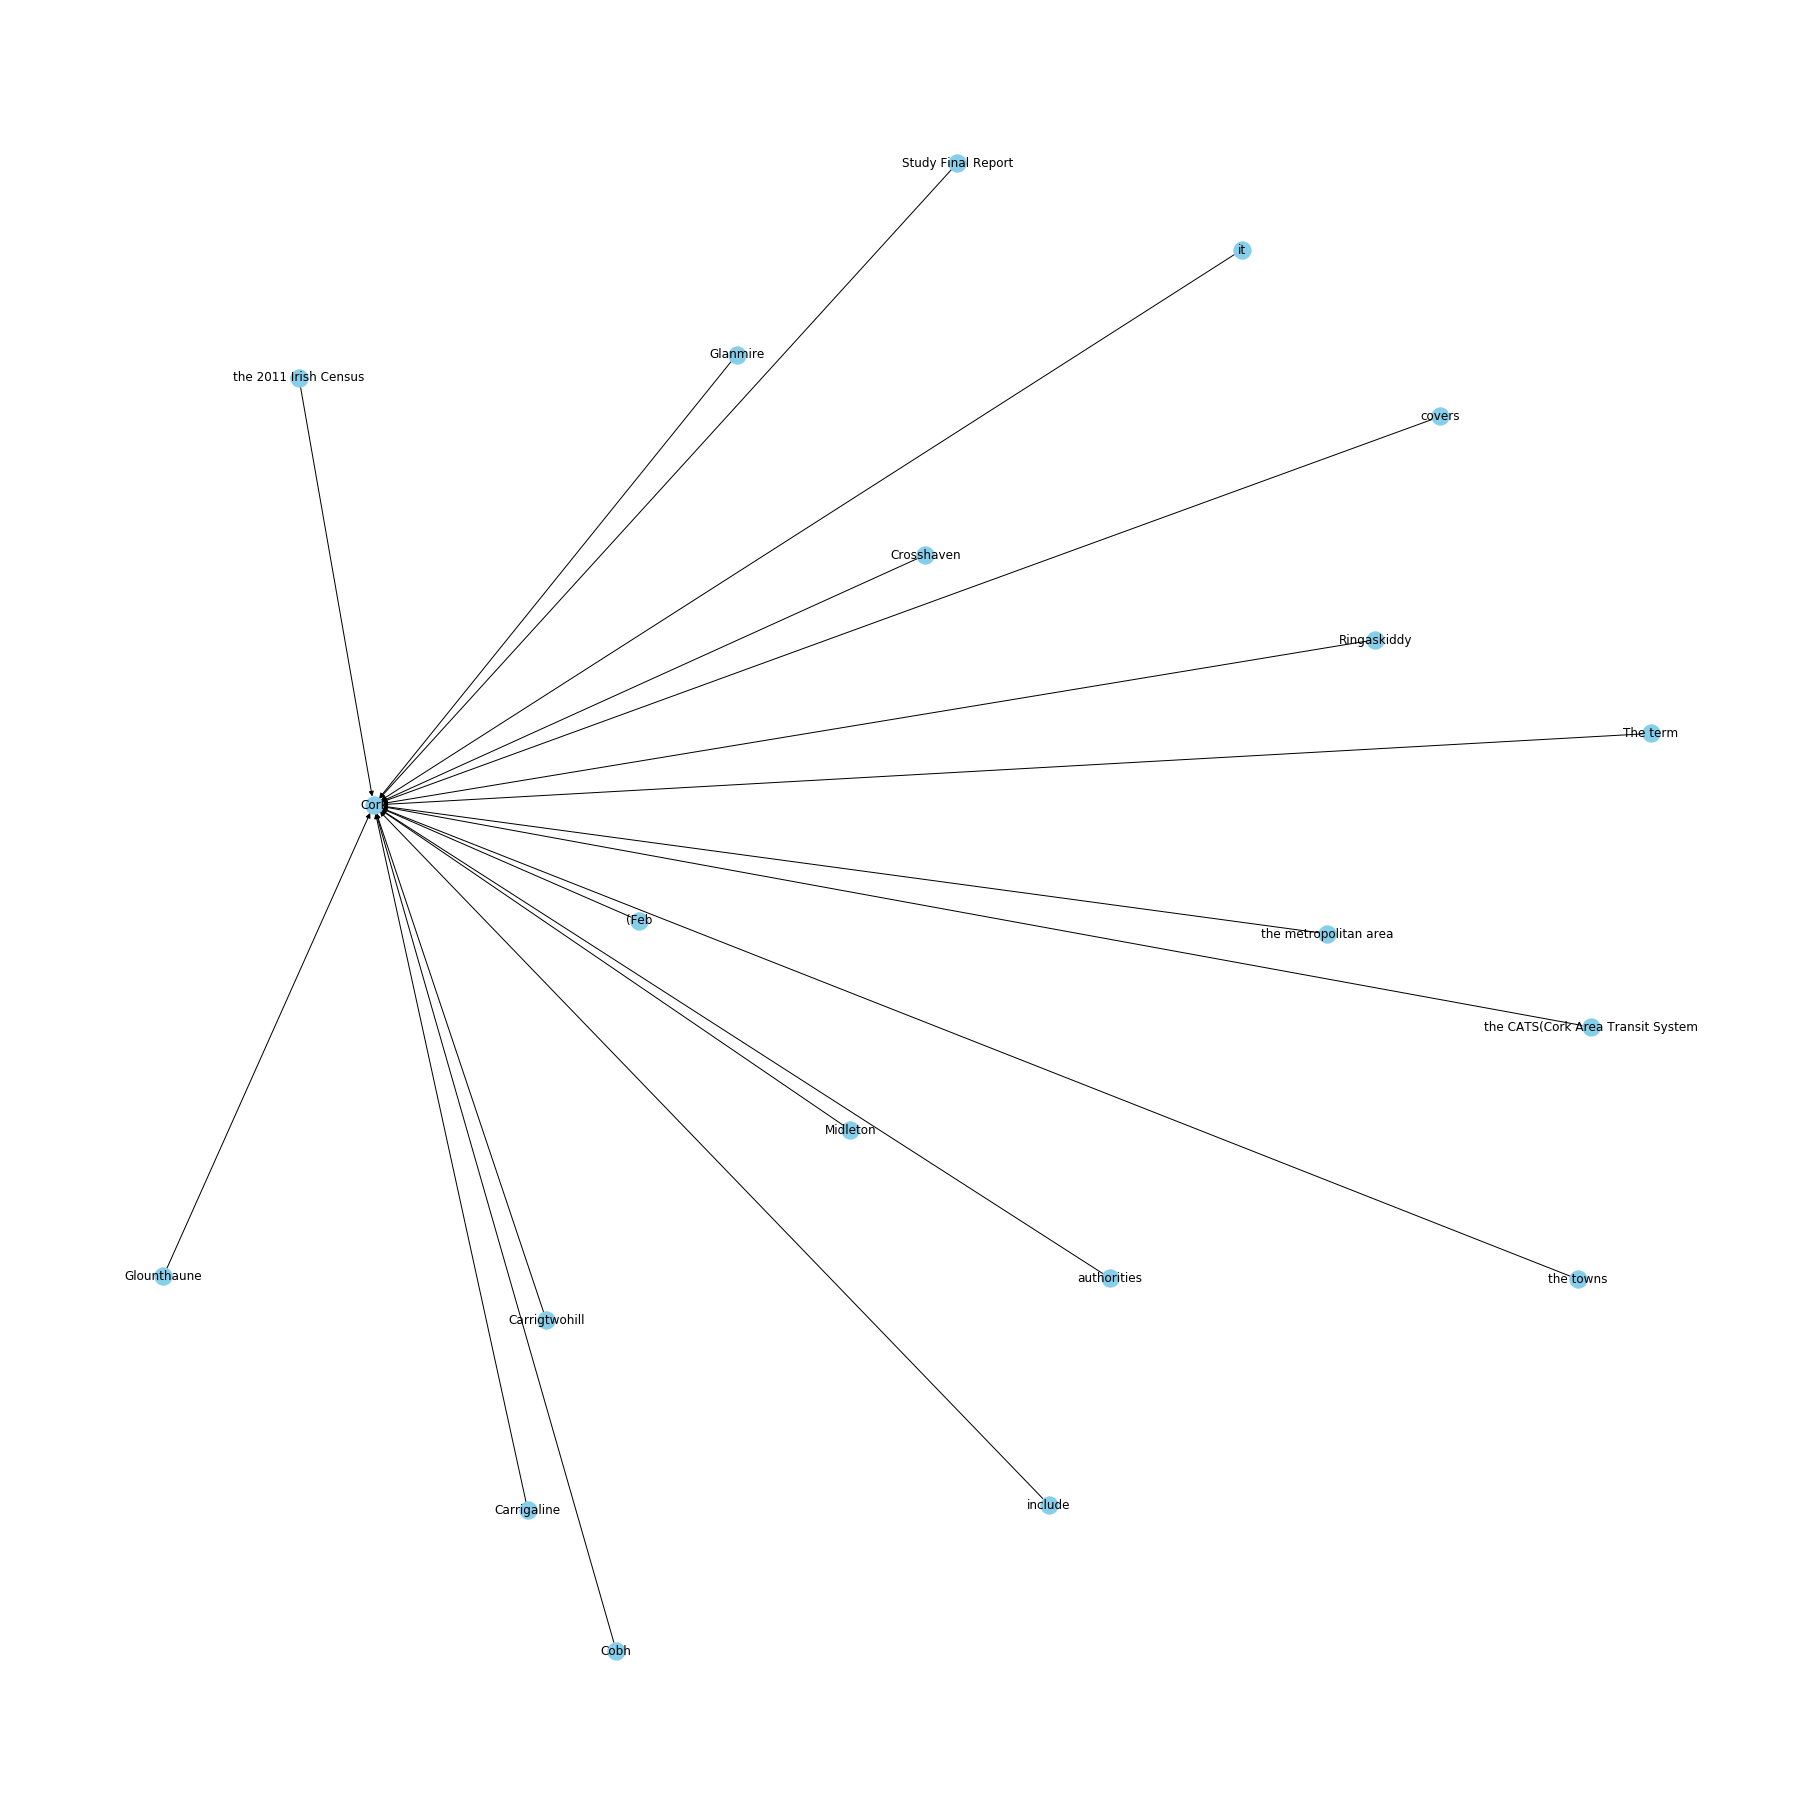

In [180]:
vizualizer(pd.DataFrame(candidate.sort_values(by='f1', ascending=False).reset_index(drop=True).iloc[3,:]).T, 'the city', default_type=False)

# add coordinates

In [267]:
from nltk.metrics.distance import jaccard_distance

In [225]:
rels = kg_df.edge.values.tolist()

In [268]:
targets = eval(some_df.target.values.tolist()[0])

In [287]:
def compare_triplets(targets, predict, dist_thresh=0.4):
    compare_result = []
    for target in targets:
        sub_compare = []
        for target_, predict_ in zip(target, predict):
            answer =  False
            dist = jaccard_distance(set(target_.lower()), set(predict_.lower()))
            if predict_ in target_ or dist < dist_thresh or target_ in predict_:
                answer = True
            sub_compare.append(answer)
        sub_compare = all(sub_compare)
        compare_result.append(sub_compare)
    closest_target = compare_result.index(True)
    return compare_result

In [288]:
vals_[0]

('Slovak', 'Ukraine', 'the western border')

In [265]:
vals_ = vals_[0] + vals_[1]

[('Slovak', 'Ukraine', 'the western border'),
 ('Slovakia', 'Ukraine', 'the western border'),
 ('Poland', 'Ukraine', 'the western border'),
 ('Slovak', 'Poland', 'the border'),
 ('the border', 'Slovakia', 'Slovak'),
 ('a significant mountain pass', 'Ukraine', 'the western border'),
 ('Przełęcz Łupkowska', 'Ukraine', 'the western border'),
 ('Łupków Pass or Lupkov Pass', 'Ukraine', 'the western border'),
 ('the border', 'Ukraine', 'the western border'),
 ('the Carpathian mountains', 'Ukraine', 'the western border'),
 ('Lupkovský priesmyk', 'Ukraine', 'the western border'),
 ('Przełęcz Łupkowska', 'Slovakia', 'Slovak'),
 ('a significant mountain pass', 'Slovakia', 'Ukraine'),
 ('a significant mountain pass', 'Slovak', 'Slovakia'),
 ('Łupków Pass or Lupkov Pass', 'Slovakia', 'Slovak'),
 ('the western border', 'Slovakia', 'Slovak'),
 ('Lupkovský priesmyk', 'Slovakia', 'Slovak'),
 ('the western border', 'Ukraine', 'Slovakia'),
 ('Łupków Pass or Lupkov Pass', 'Slovak', 'Slovakia'),
 ('the we

In [ ]:
compare_triplets(targets)

In [261]:
vals_ = [eval(val) for val in vals]

In [301]:
vals_ = []
for val in vals:
    vals_.extend(eval(val))

In [303]:
vals_

[('Slovak', 'Ukraine', 'the western border'),
 ('Slovakia', 'Ukraine', 'the western border'),
 ('Poland', 'Ukraine', 'the western border'),
 ('Slovak', 'Poland', 'the border'),
 ('the border', 'Slovakia', 'Slovak'),
 ('a significant mountain pass', 'Ukraine', 'the western border'),
 ('Przełęcz Łupkowska', 'Ukraine', 'the western border'),
 ('Łupków Pass or Lupkov Pass', 'Ukraine', 'the western border'),
 ('the border', 'Ukraine', 'the western border'),
 ('the Carpathian mountains', 'Ukraine', 'the western border'),
 ('Lupkovský priesmyk', 'Ukraine', 'the western border'),
 ('Przełęcz Łupkowska', 'Slovakia', 'Slovak'),
 ('a significant mountain pass', 'Slovakia', 'Ukraine'),
 ('a significant mountain pass', 'Slovak', 'Slovakia'),
 ('Łupków Pass or Lupkov Pass', 'Slovakia', 'Slovak'),
 ('the western border', 'Slovakia', 'Slovak'),
 ('Lupkovský priesmyk', 'Slovakia', 'Slovak'),
 ('the western border', 'Ukraine', 'Slovakia'),
 ('Łupków Pass or Lupkov Pass', 'Slovak', 'Slovakia'),
 ('the we

In [316]:
def plot_g(triplets, rel):
    
    kg_df = pd.DataFrame(triplets, columns=['source', 'target', 'edge']).drop_duplicates()
    rels = kg_df.edge.values.tolist()
    if rel:
        G=nx.from_pandas_edgelist(kg_df[kg_df['edge'].str.contains(rel)], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
    else:
        G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

    pos = nx.spring_layout(G, k=0.75, iterations=20)

    edge_labels = dict([((n1, n2), f'{rels[idx]}')
                        for idx, (n1, n2, _) in enumerate(G.edges)])
    return G, edge_labels, pos

In [345]:
def viz_extra(df, rel=None):
    vals = df.tps.values.tolist() + df.fps.values.tolist()
    targets = eval(df.target.values.tolist()[0])
    
    triplets = []
    for val in vals:
        try:
            sub_vals = list(eval(val))
        except SyntaxError:
            continue
        for sub_v in sub_vals:
            triplets.append(list(sub_v[:3]))
            
    triplets_trg = [trg[:3] for trg in targets]
    plt.figure(figsize=(25, 25))    
    G_trg, edge_labels_trg, pos_trg = plot_g(triplets_trg, rel)
    nx.draw(
        G_trg, pos_trg, edge_color='black', width=0.5, linewidths=1, font_size=9,
        node_size=700, node_color='pink', alpha=0.9,
        labels={node: node for node in G_trg.nodes()}
    )
    nx.draw_networkx_edge_labels(
        G_trg, pos_trg,
        edge_labels=edge_labels_trg,
        font_color='red'
    )
    plt.axis('off')
    plt.title('target', fontdict={'fontsize': 20})
    plt.show()
    
    plt.figure(figsize=(25, 25))    
    G, edge_labels, pos = plot_g(triplets, rel)
    for pos_name, pos_array in pos_trg.items():
        if pos_name in pos.keys():
            pos[pos_name] = pos_array
    nx.draw(
        G, pos, edge_color='black', width=0.5, linewidths=1, font_size=9,
        node_size=700, node_color='pink', alpha=0.9,
        labels={node: node for node in G.nodes()}
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_color='red'
    )
    plt.axis('off')
    filename = 'full_rels' if not rel else rel
    plt.savefig(f'{filename}.png', dpi=500)
    plt.title('predict', fontdict={'fontsize': 20})

In [354]:
pos

{'Slovak': array([ 1.        , -0.84169198]),
 'Ukraine': array([-0.00085794,  0.01040551]),
 'Slovakia': array([-0.99487034,  0.83662502]),
 'Poland': array([-0.84872538, -0.99440214]),
 'the border': array([0.7671582 , 0.41221294]),
 'a significant mountain pass': array([-0.56424067,  0.06686644]),
 'Przełęcz Łupkowska': array([0.78248878, 0.02139345]),
 'Łupków Pass or Lupkov Pass': array([ 0.66304423, -0.43434494]),
 'the Carpathian mountains': array([-0.34372153, -0.58643782]),
 'Lupkovský priesmyk': array([0.29076783, 0.71865697]),
 'the western border': array([0.50638917, 0.64388408]),
 'It': array([-0.00945952, -0.62036465]),
 'Medzilaborce': array([-0.48918428, -0.53354518]),
 'Łupków': array([-0.80666896,  0.50671699]),
 'the village': array([-0.35891604, -0.08564942]),
 'runs': array([-0.76043954, -0.19572458]),
 'Underneath': array([-0.53102852,  0.70224174]),
 'the rest': array([-0.07811052,  0.56165163]),
 'Galicia': array([0.58689637, 0.11199941]),
 'link': array([ 0.483

In [355]:
pos_trg

{'Polish': array([0.84445365, 0.98906358]),
 'Slovak': array([ 1.        , -0.84169198]),
 'Slovakia': array([-0.99487034,  0.83662502]),
 'Ukraine': array([-0.00085794,  0.01040551]),
 'Poland': array([-0.84872538, -0.99440214])}

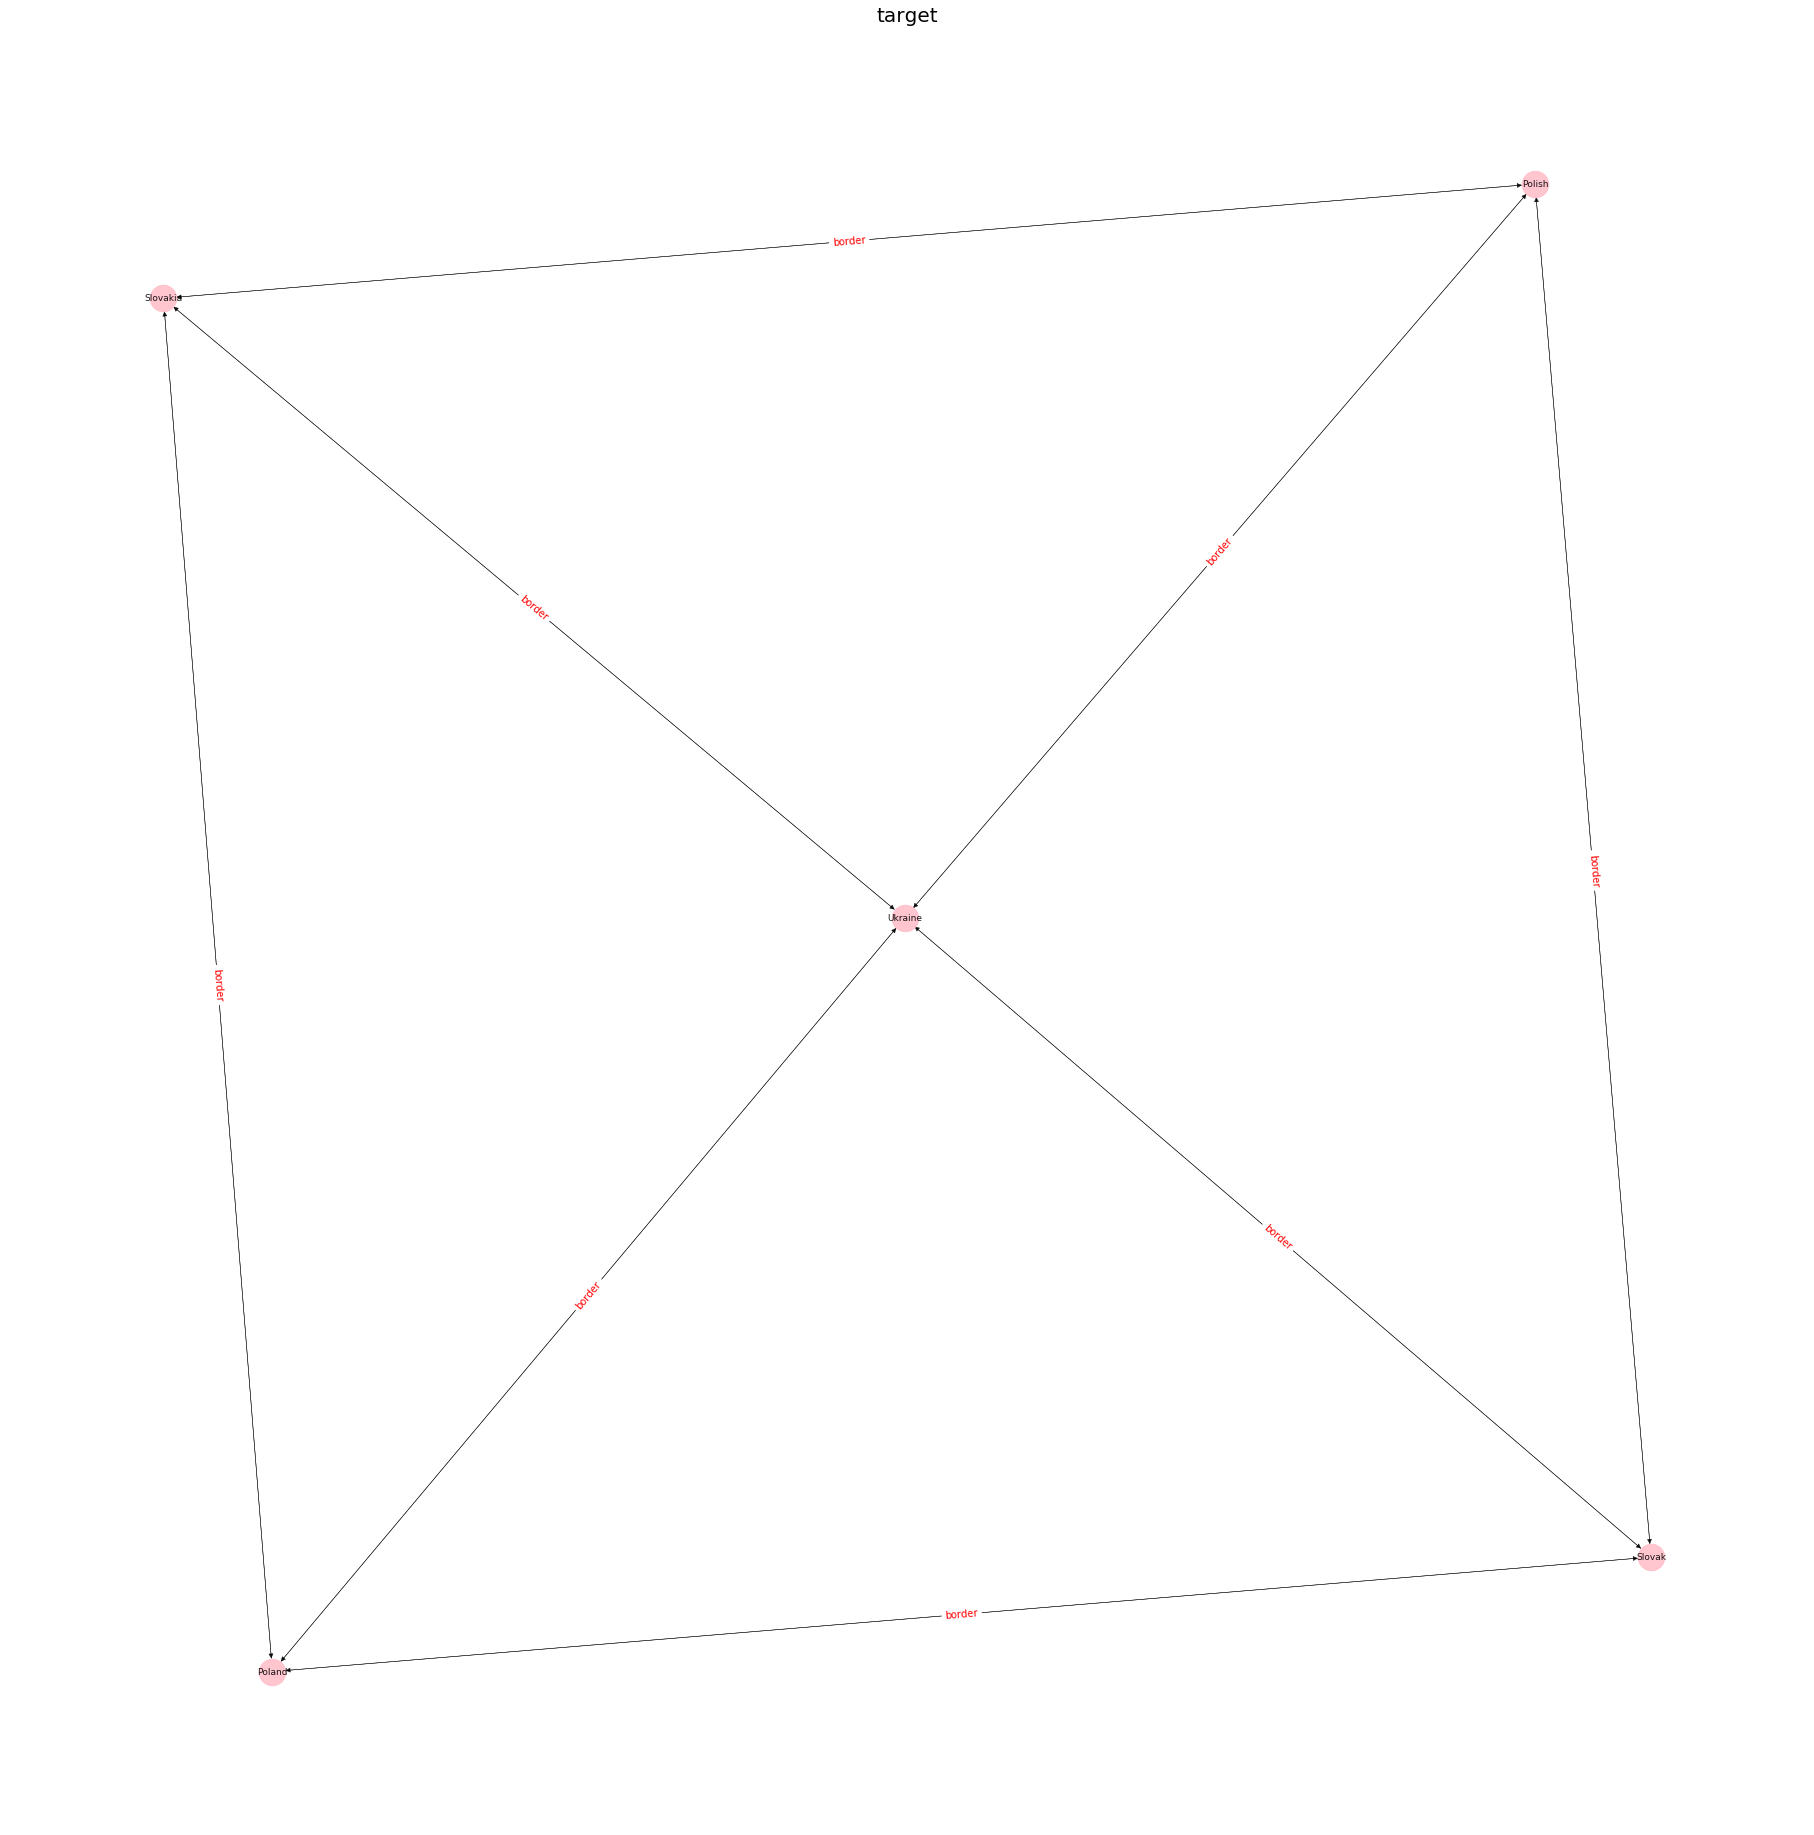

Text(0.5, 1, 'predict')

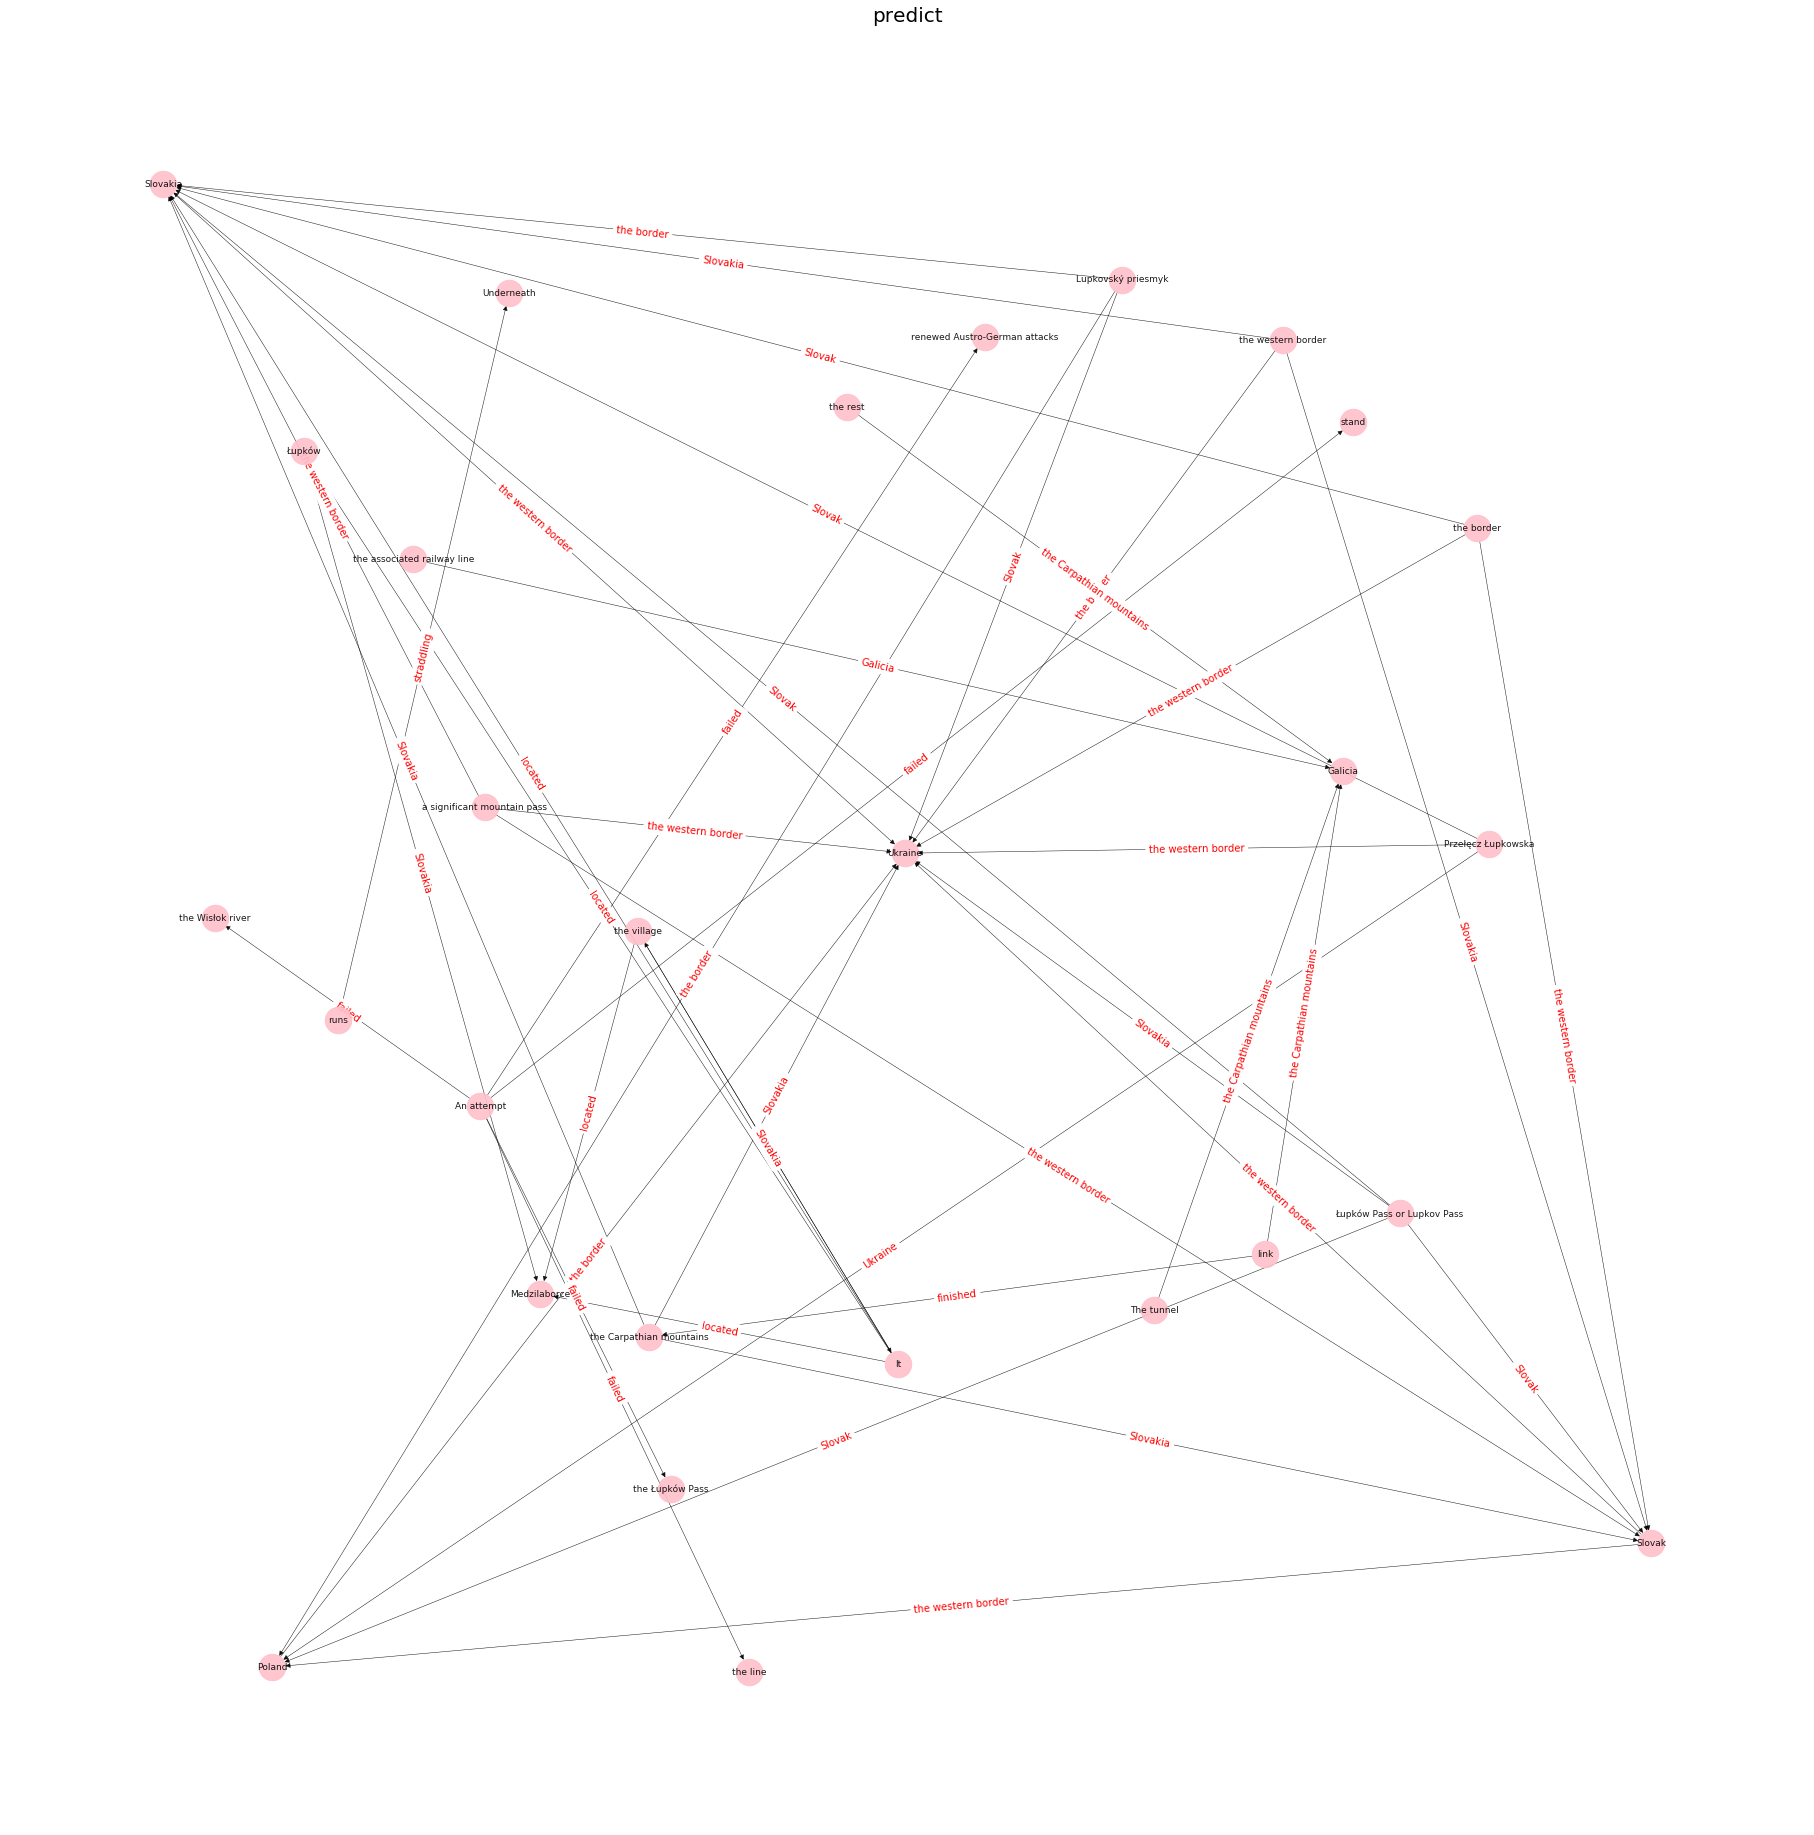

In [353]:
vals = df.tps.values.tolist() + df.fps.values.tolist()
targets = eval(df.target.values.tolist()[0])

triplets = []
for val in vals:
    try:
        sub_vals = list(eval(val))
    except SyntaxError:
        continue
    for sub_v in sub_vals:
        triplets.append(list(sub_v[:3]))

triplets_trg = [trg[:3] for trg in targets]
plt.figure(figsize=(25, 25))    
G_trg, edge_labels_trg, pos_trg = plot_g(triplets_trg, rel)
nx.draw(
    G_trg, pos_trg, edge_color='black', width=0.5, linewidths=1, font_size=9,
    node_size=700, node_color='pink', alpha=0.9,
    labels={node: node for node in G_trg.nodes()}
)
nx.draw_networkx_edge_labels(
    G_trg, pos_trg,
    edge_labels=edge_labels_trg,
    font_color='red'
)
plt.axis('off')
plt.savefig(f'target.png', dpi=500)
plt.title('target', fontdict={'fontsize': 20})
plt.show()

plt.figure(figsize=(25, 25))    
G, edge_labels, pos = plot_g(triplets, rel)
for pos_name, pos_array in pos_trg.items():
    if pos_name in pos.keys():
        pos[pos_name] = pos_array
nx.draw(
    G, pos, edge_color='black', width=0.5, linewidths=1, font_size=9,
    node_size=700, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red'
)
plt.axis('off')
filename = 'full_rels' if not rel else rel
plt.savefig(f'predict.png', dpi=500)
plt.title('predict', fontdict={'fontsize': 20})

In [296]:
pos

{'Polish': array([0.86642589, 0.56047377]),
 'Slovak': array([ 0.93541263, -0.45432253]),
 'Slovakia': array([-0.46016345, -1.        ]),
 'Ukraine': array([-0.77967763, -0.04567616]),
 'Poland': array([-0.56199744,  0.93952493])}

In [306]:
pos

{'Slovak': array([ 0.90564736, -0.01979854]),
 'Ukraine': array([-0.0752387, -1.       ]),
 'Slovakia': array([-0.80758772,  0.41382386]),
 'Poland': array([-0.24426722,  0.81771619]),
 'the border': array([ 0.31264193, -0.36811133]),
 'a significant mountain pass': array([-0.4264992 , -0.08307523]),
 'Przełęcz Łupkowska': array([-0.27569075,  0.25583837]),
 'Łupków Pass or Lupkov Pass': array([ 0.08821648, -0.05990798]),
 'the Carpathian mountains': array([0.27658076, 0.64835987]),
 'Lupkovský priesmyk': array([0.4311532 , 0.02424215]),
 'the western border': array([-0.55414528,  0.03837313]),
 'It': array([-0.1115855 , -0.54483563]),
 'Medzilaborce': array([-0.89907107, -0.21964502]),
 'Łupków': array([-0.33399756, -0.60873374]),
 'the village': array([0.13331071, 0.2085045 ]),
 'runs': array([0.98248251, 0.27176439]),
 'Underneath': array([-0.39584544, -0.91763404]),
 'the rest': array([0.72905757, 0.5235819 ]),
 'Galicia': array([-0.42026796,  0.80452479]),
 'link': array([ 0.74549